# Extração de Frames de Vídeos de Sutura Cirúrgica

Este notebook implementa e explica diferentes técnicas para extração de frames a partir dos vídeos de sutura cirúrgica. A extração eficiente e representativa de frames é um passo fundamental para o processamento posterior e análise dos procedimentos cirúrgicos.

## Objetivos
- Implementar diferentes estratégias de extração de frames
- Comparar métodos de amostragem uniforme vs. adaptativa
- Analisar a eficiência computacional das diferentes abordagens
- Salvar os frames extraídos para uso em etapas posteriores

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import time
from skimage.metrics import structural_similarity as ssim

%matplotlib inline

## 1. Carregamento dos Dados

Vamos carregar a lista de vídeos e as estatísticas coletadas anteriormente.

In [2]:
dataset_path = "../../dataset"
output_path = "../data/processed/frames"

os.makedirs(output_path, exist_ok=True)

video_files = glob.glob(os.path.join(dataset_path, "**/*.mp4"), recursive=True)
print(f"Total de vídeos encontrados: {len(video_files)}")

# Carregar estatísticas dos vídeos, obtidas a partir do notebook 02 da análise de dados (se disponíveis)
try:
    stats_df = pd.read_csv('../data/video_statistics.csv')
    print(f"Estatísticas carregadas para {len(stats_df)} vídeos")
except FileNotFoundError:
    print("Arquivo de estatísticas não encontrado. Continuando sem estatísticas prévias.")
    stats_df = None

Total de vídeos encontrados: 30
Estatísticas carregadas para 30 vídeos


## 2. Métodos de Extração de Frames

Vamos implementar diferentes estratégias para extração de frames dos vídeos.

In [ ]:
def extract_frames_uniform(video_path, output_dir, n_frames=30, prefix="frame"):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_output_dir = os.path.join(output_dir, video_name, "uniform")
    os.makedirs(video_output_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Erro ao abrir o vídeo: {video_path}")
        return []
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    n_frames = min(n_frames, total_frames)
    
    frame_indices = np.linspace(0, total_frames - 1, n_frames, dtype=int)
    
    frame_paths = []
    
    for i, frame_idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if ret:
            frame_path = os.path.join(video_output_dir, f"{prefix}_{i:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)
    
    cap.release()
    
    return frame_paths

def extract_frames_by_time(video_path, output_dir, interval_sec=1.0, prefix="frame"):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_output_dir = os.path.join(output_dir, video_name, "time_interval")
    os.makedirs(video_output_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Erro ao abrir o vídeo: {video_path}")
        return []
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    n_frames = int(duration / interval_sec) + 1
    
    frame_paths = []
    frame_count = 0
    
    for i in range(n_frames):
        timestamp = i * interval_sec
        
        frame_idx = int(timestamp * fps)
        
        if frame_idx >= total_frames:
            break
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if ret:
            frame_path = os.path.join(video_output_dir, f"{prefix}_{frame_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)
            frame_count += 1
    
    cap.release()
    
    return frame_paths

def extract_frames_adaptive(video_path, output_dir, threshold=0.9, max_frames=100, prefix="frame", skip_frames=5):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_output_dir = os.path.join(output_dir, video_name, "adaptive")
    os.makedirs(video_output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[ERRO] Não foi possível abrir o vídeo: {video_path}")
        return []

    frame_paths = []
    saved_frames = 0
    frame_index = 0
    last_saved_gray = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if last_saved_gray is None:
            frame_path = os.path.join(video_output_dir, f"{prefix}_{frame_index:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)
            last_saved_gray = frame_gray
            saved_frames += 1
        else:
            similarity = ssim(last_saved_gray, frame_gray)
            if similarity < threshold:
                frame_path = os.path.join(video_output_dir, f"{prefix}_{frame_index:04d}.jpg")
                cv2.imwrite(frame_path, frame)
                frame_paths.append(frame_path)
                last_saved_gray = frame_gray
                saved_frames += 1

        if saved_frames >= max_frames:
            break

        frame_index += skip_frames
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    cap.release()
    return frame_paths

def extract_frames_keypoints(video_path, output_dir, min_keypoints=10, max_frames=100, prefix="frame"):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_output_dir = os.path.join(output_dir, video_name, "keypoints")
    os.makedirs(video_output_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Erro ao abrir o vídeo: {video_path}")
        return []

    sift = cv2.SIFT_create()

    frame_paths = []
    frame_count = 0
    processed_count = 0

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()

        if not ret:
            break

        processed_count += 1
        if processed_count % 5 != 0:
            continue

        # Converter para escala de cinza
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detectar keypoints
        keypoints = sift.detect(gray, None)

        # Se o número de keypoints for suficiente, guardar o frame
        if len(keypoints) >= min_keypoints:
            frame_path = os.path.join(video_output_dir, f"{prefix}_{frame_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)
            frame_count += 1

    cap.release()

    return frame_paths

## 3. Comparação dos Métodos de Extração

Vamos comparar os diferentes métodos de extração em um vídeo de exemplo.

Vídeo de exemplo: A88O.mp4

A testar métodos de extração de frames...
Extração uniforme: 20 frames em 2.06 segundos
Extração por intervalo de tempo: 160 frames em 24.16 segundos
Extração adaptativa: 9 frames em 5.75 segundos
Extração baseada em keypoints: 20 frames em 8.38 segundos


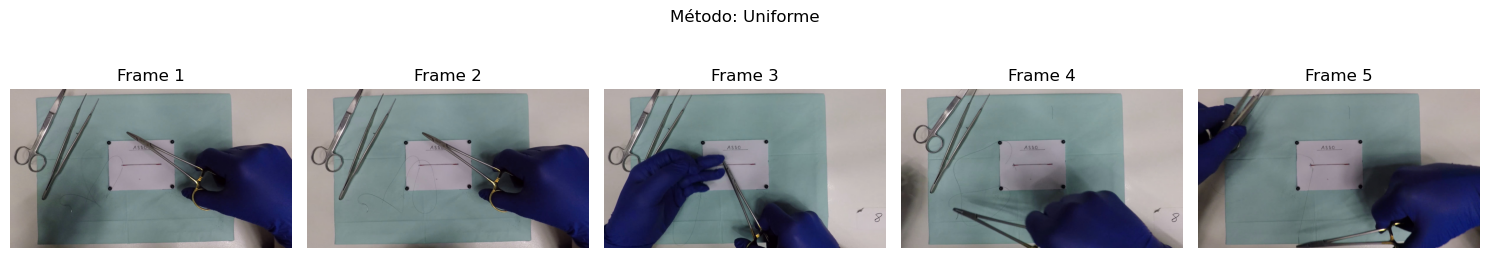

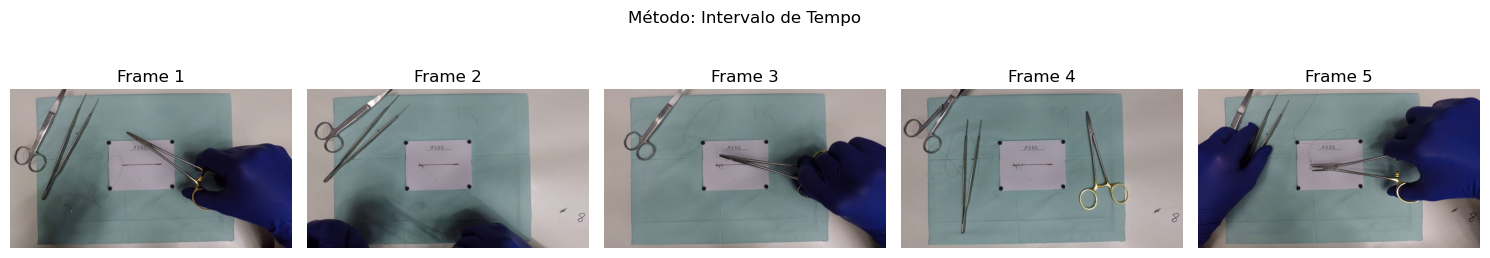

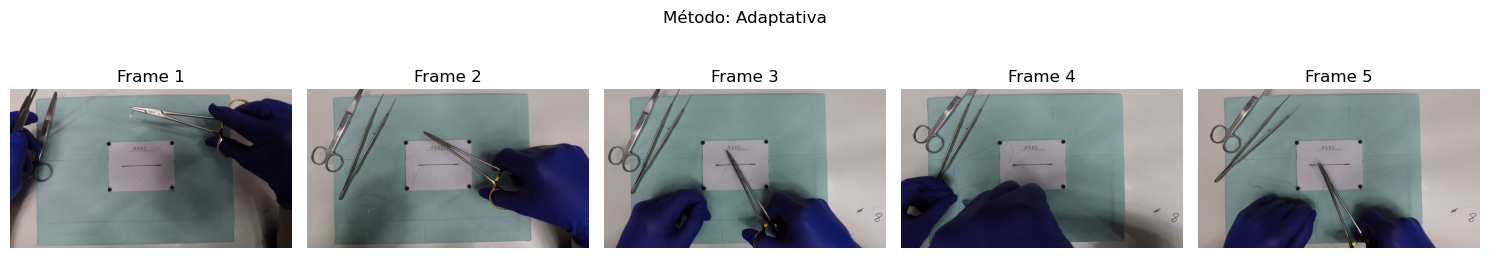

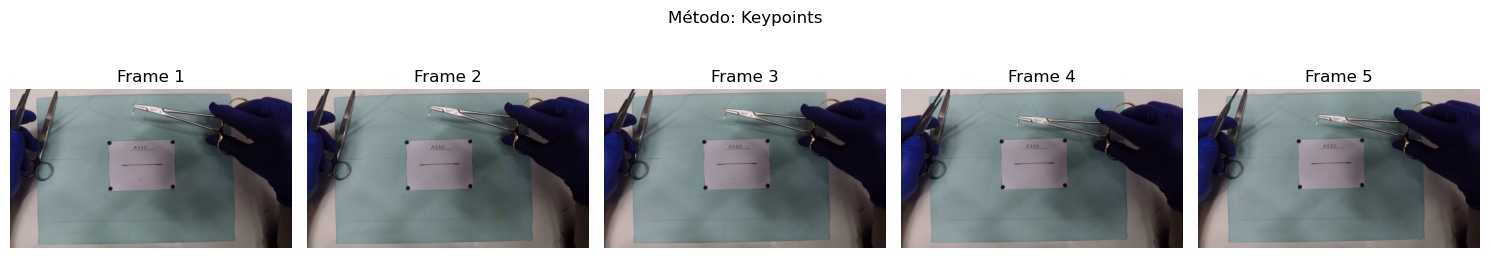

In [4]:
if video_files:
    sample_video = video_files[0]
    print(f"Vídeo de exemplo: {os.path.basename(sample_video)}")
    
    test_output_dir = os.path.join(output_path, "test")
    os.makedirs(test_output_dir, exist_ok=True)
    
    print("\nA testar métodos de extração de frames...")
    
    # Método 1: Extração uniforme
    start_time = time.time()
    uniform_frames = extract_frames_uniform(sample_video, test_output_dir, n_frames=20)
    uniform_time = time.time() - start_time
    print(f"Extração uniforme: {len(uniform_frames)} frames em {uniform_time:.2f} segundos")
    
    # Método 2: Extração por intervalo de tempo
    start_time = time.time()
    time_frames = extract_frames_by_time(sample_video, test_output_dir, interval_sec=2.0)
    time_interval_time = time.time() - start_time
    print(f"Extração por intervalo de tempo: {len(time_frames)} frames em {time_interval_time:.2f} segundos")
    
    # Método 3: Extração adaptativa
    start_time = time.time()
    adaptive_frames = extract_frames_adaptive(sample_video, test_output_dir, threshold=0.8, max_frames=20)
    adaptive_time = time.time() - start_time
    print(f"Extração adaptativa: {len(adaptive_frames)} frames em {adaptive_time:.2f} segundos")
    
    # Método 4: Extração baseada em keypoints
    start_time = time.time()
    keypoints_frames = extract_frames_keypoints(sample_video, test_output_dir, min_keypoints=20, max_frames=20)
    keypoints_time = time.time() - start_time
    print(f"Extração baseada em keypoints: {len(keypoints_frames)} frames em {keypoints_time:.2f} segundos")
    
    # Visualizar alguns frames extraídos de cada método
    methods = {
        "Uniforme": uniform_frames[:5],
        "Intervalo de Tempo": time_frames[:5],
        "Adaptativa": adaptive_frames[:5],
        "Keypoints": keypoints_frames[:5]
    }
    
    for method_name, frames in methods.items():
        if frames:
            plt.figure(figsize=(15, 3))
            plt.suptitle(f"Método: {method_name}")
            
            for i, frame_path in enumerate(frames):
                plt.subplot(1, 5, i+1)
                frame = cv2.imread(frame_path)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                plt.imshow(frame)
                plt.title(f"Frame {i+1}")
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
else:
    print("Nenhum vídeo encontrado no dataset.")

## 4. Análise Comparativa dos Métodos

Vamos analisar as vantagens e desvantagens de cada método de extração.

### Comparação dos Métodos de Extração de Frames

| Método | Vantagens | Desvantagens | Uso Recomendado |
|--------|-----------|--------------|------------------|
| **Uniforme** | - Simples e rápido<br>- Garante cobertura de todo o vídeo<br>- Número fixo de frames | - Pode perder eventos importantes<br>- Não considera o conteúdo | - Quando se deseja uma visão geral do vídeo<br>- Para vídeos com mudanças graduais |
| **Intervalo de Tempo** | - Intuitivo e previsível<br>- Bom para análise temporal<br>- Fácil de implementar | - Pode gerar muitos frames redundantes<br>- Não considera o conteúdo | - Para análise de procedimentos com duração conhecida<br>- Quando a taxa de amostragem temporal é importante |
| **Adaptativo** | - Reduz redundância<br>- Captura mudanças significativas<br>- Eficiente em armazenamento | - Mais lento que métodos uniformes<br>- Requer ajuste de parâmetros | - Para vídeos com mudanças abruptas<br>- Quando a eficiência de armazenamento é importante |
| **Keypoints** | - Foca em frames com conteúdo relevante<br>- Bom para detecção de instrumentos<br>- Ignora frames sem informação | - Computacionalmente intensivo<br>- Pode perder frames importantes com poucos keypoints | - Para detecção de instrumentos cirúrgicos<br>- Quando a análise de conteúdo é prioritária |

### Considerações para Escolha do Método

A escolha do método de extração de frames deve considerar:

1. **Objetivo da análise**: Para segmentação temporal, métodos uniformes ou por intervalo de tempo podem ser mais adequados. Para detecção de erros ou análise de instrumentos, métodos adaptativos ou baseados em keypoints podem ser melhores.

2. **Recursos computacionais**: Métodos adaptativos e baseados em keypoints são mais intensivos computacionalmente.

3. **Volume de dados**: Para grandes volumes de vídeos, métodos que reduzem redundância (adaptativo) podem ser preferíveis.

4. **Características dos vídeos**: Vídeos com muitas mudanças rápidas podem beneficiar de métodos adaptativos, enquanto vídeos mais estáticos podem usar amostragem uniforme.

### Para o Projeto

Para o desafio de análise de sutura cirúrgica, uma abordagem híbrida parece ser a mais eficaz:

1. Usar extração uniforme para criar uma linha de base de frames para segmentação temporal
2. Complementar com extração adaptativa para capturar eventos importantes
3. Aplicar extração baseada em keypoints especificamente para análise de instrumentos e técnicas

Considerando o contexto do problema, um pipeline deste tipo parece mais adequado e permite-nos utilizar diversos métodos diferentes que, de certa forma, se complementam.

## 5. Processamento em Lote

Vamos implementar o processamento em lote para extrair frames de todos os vídeos do dataset.

In [5]:
def process_video(video_path, output_dir, methods=['uniform']):
    results = {}
    video_name = os.path.splitext(os.path.basename(video_path))[0]
        
    try:
        if 'uniform' in methods:
            results['uniform'] = extract_frames_uniform(video_path, output_dir, n_frames=20)
            
        if 'time' in methods:
            results['time'] = extract_frames_by_time(video_path, output_dir, interval_sec=2.0)
            
        if 'adaptive' in methods:
            results['adaptive'] = extract_frames_adaptive(video_path, output_dir, threshold=0.8, max_frames=20)
            
        if 'keypoints' in methods:
            results['keypoints'] = extract_frames_keypoints(video_path, output_dir, min_keypoints=20, max_frames=20)
    
    except Exception as e:
        print(f"Erro ao processar {video_name}: {e}")
    
    return {
        'video_name': video_name,
        'results': results
    }

process_all = True
methods = ['uniform', 'time', 'adaptive', 'keypoints']

if process_all:
    print(f"\nA processar {len(video_files)} vídeos com os métodos: {', '.join(methods)}")
    
    results = []
    for video_path in tqdm(video_files, desc="A processar vídeos"):
        result = process_video(video_path, output_path, methods)
        results.append(result)
    
    print("\nResumo do processamento:")
    for result in results:
        video_name = result['video_name']
        print(f"\n{video_name}:")
        
        for method, frames in result['results'].items():
            print(f"  - {method}: {len(frames)} frames")
    
    metadata = []
    for result in results:
        video_name = result['video_name']
        
        for method, frames in result['results'].items():
            for frame_path in frames:
                metadata.append({
                    'video_name': video_name,
                    'method': method,
                    'frame_path': frame_path,
                    'frame_name': os.path.basename(frame_path)
                })
    
    metadata_df = pd.DataFrame(metadata)
    metadata_df.to_csv(os.path.join(output_path, 'frames_metadata.csv'), index=False)
    print(f"\nMetadados salvos em {os.path.join(output_path, 'frames_metadata.csv')}")
else:
    print("Processamento em lote cancelado.")


A processar 30 vídeos com os métodos: uniform, time, adaptive, keypoints


A processar vídeos:   0%|          | 0/30 [00:00<?, ?it/s]


Resumo do processamento:

A88O:
  - uniform: 20 frames
  - time: 160 frames
  - adaptive: 9 frames
  - keypoints: 20 frames

A80U:
  - uniform: 20 frames
  - time: 151 frames
  - adaptive: 5 frames
  - keypoints: 20 frames

A40E:
  - uniform: 20 frames
  - time: 151 frames
  - adaptive: 9 frames
  - keypoints: 20 frames

A99X:
  - uniform: 20 frames
  - time: 150 frames
  - adaptive: 9 frames
  - keypoints: 20 frames

B12G:
  - uniform: 20 frames
  - time: 151 frames
  - adaptive: 1 frames
  - keypoints: 20 frames

C16G:
  - uniform: 20 frames
  - time: 151 frames
  - adaptive: 6 frames
  - keypoints: 20 frames

A83X:
  - uniform: 20 frames
  - time: 150 frames
  - adaptive: 8 frames
  - keypoints: 20 frames

C28D:
  - uniform: 20 frames
  - time: 150 frames
  - adaptive: 8 frames
  - keypoints: 20 frames

C43T:
  - uniform: 20 frames
  - time: 150 frames
  - adaptive: 4 frames
  - keypoints: 20 frames

C46R:
  - uniform: 20 frames
  - time: 151 frames
  - adaptive: 1 frames
  - keypo

## 6. Visualização dos Resultados

Vamos visualizar alguns dos frames extraídos para verificar a qualidade e representatividade.

Metadados carregados: 5906 frames de 30 vídeos

Frames por método:
  - adaptive: 169 frames
  - keypoints: 600 frames
  - time: 4537 frames
  - uniform: 600 frames

A visualizar frames do vídeo: A88O


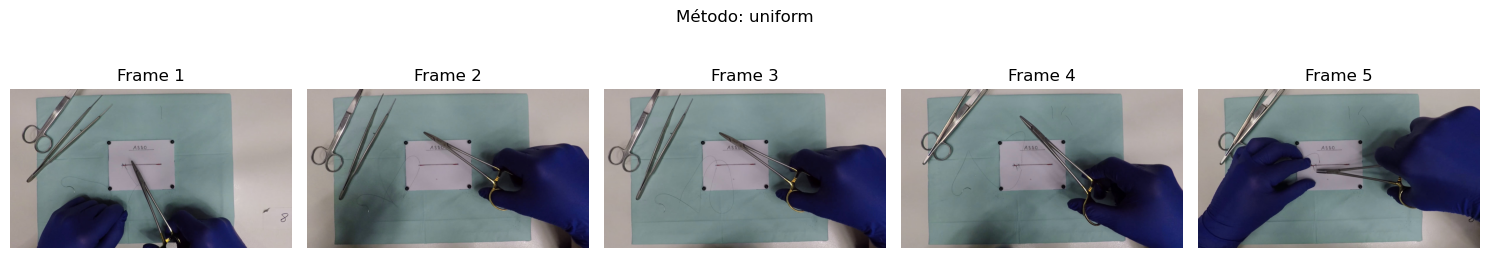

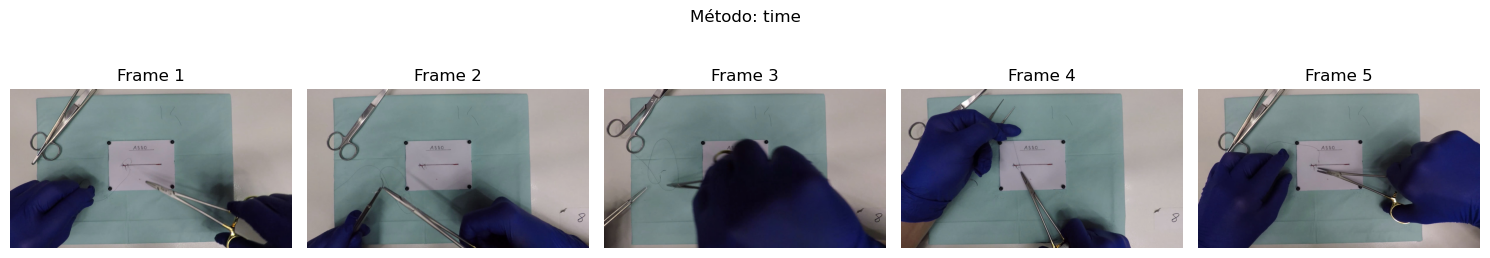

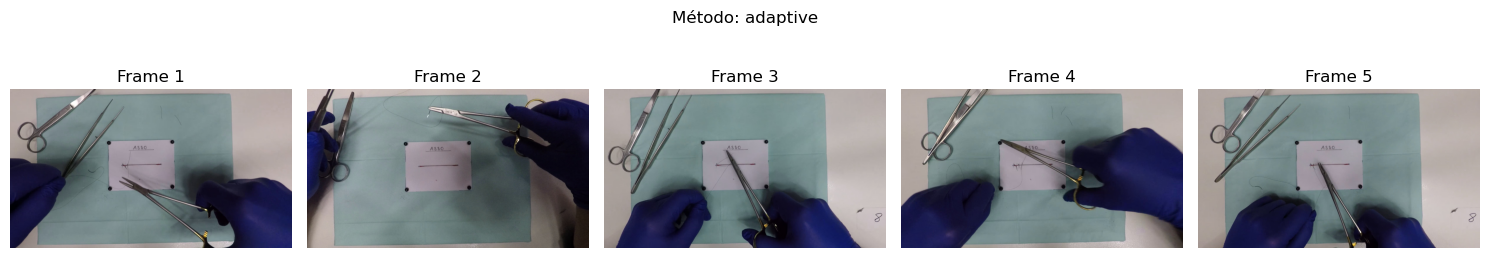

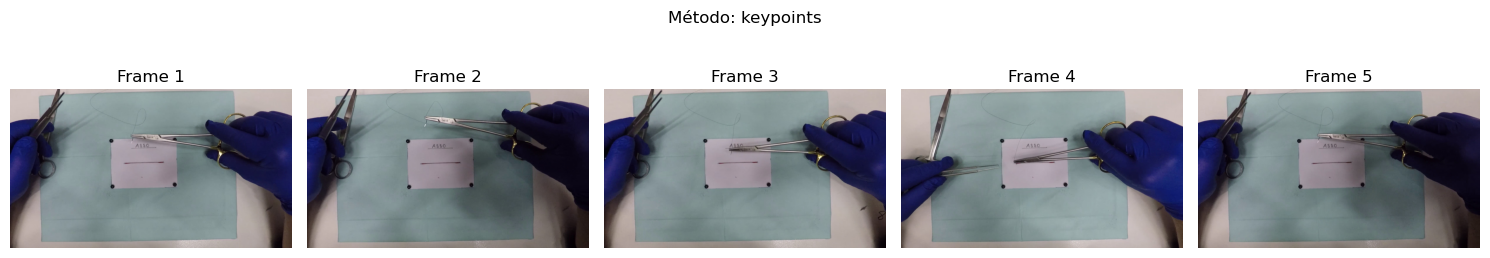

In [6]:
metadata_path = os.path.join(output_path, 'frames_metadata.csv')

if os.path.exists(metadata_path):
    metadata_df = pd.read_csv(metadata_path)
    print(f"Metadados carregados: {len(metadata_df)} frames de {metadata_df['video_name'].nunique()} vídeos")
    
    method_stats = metadata_df.groupby('method').size()
    print("\nFrames por método:")
    for method, count in method_stats.items():
        print(f"  - {method}: {count} frames")
    
    video_names = metadata_df['video_name'].unique()
    
    if len(video_names) > 0:
        sample_video_name = video_names[0]
        print(f"\nA visualizar frames do vídeo: {sample_video_name}")
        
        video_frames = metadata_df[metadata_df['video_name'] == sample_video_name]
        
        for method in video_frames['method'].unique():
            method_frames = video_frames[video_frames['method'] == method]
            
            sample_frames = method_frames.sample(min(5, len(method_frames)))['frame_path'].tolist()
            
            if sample_frames:
                plt.figure(figsize=(15, 3))
                plt.suptitle(f"Método: {method}")
                
                for i, frame_path in enumerate(sample_frames):
                    plt.subplot(1, 5, i+1)
                    frame = cv2.imread(frame_path)
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    plt.imshow(frame)
                    plt.title(f"Frame {i+1}")
                    plt.axis('off')
                
                plt.tight_layout()
                plt.show()
else:
    print("Metadados não encontrados. Execute o processamento em lote primeiro.")

## 7. Conclusões e Próximos Passos

Neste notebook, implementamos e comparamos diferentes métodos para extração de frames de vídeos de sutura cirúrgica. Cada método tem suas vantagens e desvantagens, e a escolha do método mais adequado depende dos objetivos específicos da análise.

### Principais Conclusões

1. **Métodos Uniformes e por Intervalo de Tempo**: São simples e eficientes, garantindo uma cobertura temporal completa do vídeo. São ideais para análise de sequências temporais e segmentação de fases.

2. **Métodos Adaptativos**: Reduzem a redundância e capturam mudanças significativas no conteúdo do vídeo. São úteis para identificar eventos importantes e transições entre fases.

3. **Métodos Baseados em Keypoints**: Focam em frames com conteúdo visualmente relevante, como a presença de instrumentos cirúrgicos. São valiosos para análise de técnicas e detecção de erros.

### Próximos Passos

1. **Pré-processamento dos Frames**: Aplicar técnicas de pré-processamento nos frames extraídos, como normalização, redimensionamento e aumento de dados.

2. **Extração de Features**: Extrair características relevantes dos frames para alimentar modelos de aprendizado profundo.

3. **Segmentação Temporal**: Utilizar os frames extraídos para desenvolver modelos de segmentação temporal que identifiquem as diferentes fases da sutura.

4. **Detecção de Erros**: Desenvolver modelos para identificar erros técnicos nos procedimentos de sutura.

5. **Integração com Metadados**: Combinar a análise visual com metadados temporais para uma compreensão mais completa dos procedimentos.

In [7]:
config = {
    'output_path': output_path,
    'methods_used': methods if process_all else ['uniform'],
    'metadata_path': metadata_path if process_all else None
}

import json
with open('../data/frame_extraction_config.json', 'w') as f:
    json.dump(config, f)

print("Configuração guardada para uso noutros notebooks.")

Configuração guardada para uso noutros notebooks.
